In [1]:
%load_ext sql
%sql sqlite://///home/mikew/extracover/male_t20.db

Tip: You may define configurations in /home/mikew/extracover/pyproject.toml or /home/mikew/.jupysql/config.

Did not find user configurations in /home/mikew/extracover/pyproject.toml.

Connecting to 'sqlite://///home/mikew/extracover/male_t20.db'

In [2]:
%config SqlMagic.displaylimit=20

## Run distribution by phase of innings

In [3]:
qry = """
WITH phased AS (
    SELECT
        *
    ,   CASE
        WHEN over BETWEEN 0 AND 5 THEN '0 powerplay'
        WHEN over BETWEEN 6 AND 17 THEN '1 mid-innings'
        ELSE '2 last two'
        END as phase
    FROM balls
)
SELECT phase, batter_runs, COUNT(*) AS count
FROM phased
WHERE innings < 2
AND extra_type = ''
AND batter_runs in (0,1,2,3,4,6)
GROUP BY phase, batter_runs
"""
result = %sql {{qry}}
df=result.DataFrame()
df.pivot(columns="phase", index="batter_runs", values="count")

Running query in 'sqlite://///home/mikew/extracover/male_t20.db'

phase,0 powerplay,1 mid-innings,2 last two
batter_runs,,,
0,255696,331451,37221
1,150345,460746,45550
2,26295,77402,15030
3,3209,3431,575
4,80103,89359,15193
6,19391,48887,11072


## Average runs by over

Running query in 'sqlite://///home/mikew/extracover/male_t20.db'

<Axes: xlabel='over'>

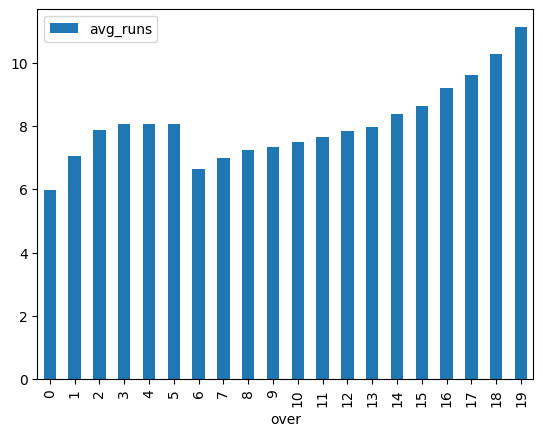

In [4]:
sql= """
WITH over_runs AS (
SELECT
	over
,	CAST(SUM(batter_runs) + SUM(extra_runs) AS FLOAT) AS runs
FROM balls
WHERE innings = 0
GROUP BY match_id, over
HAVING MAX(ball) = 5
)
SELECT
	over
,	SUM(runs) / COUNT(*) AS avg_runs
FROM over_runs
GROUP BY over
ORDER BY over
"""

result=%sql {{sql}}
df=result.DataFrame()
df.plot(x="over", y="avg_runs", kind="bar")

## Batsman "Aggression"

First, what's the average *batter only* runs per ball in each over?

Running query in 'sqlite://///home/mikew/extracover/male_t20.db'

<Axes: xlabel='over'>

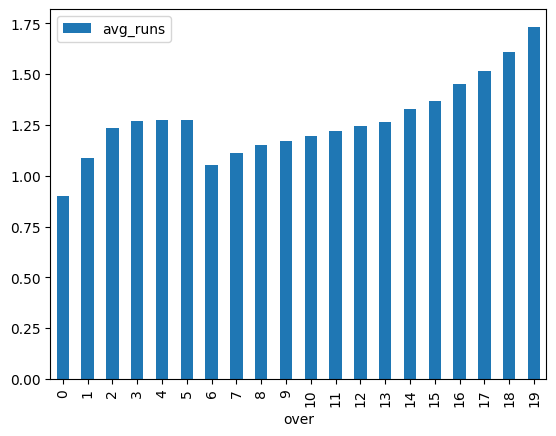

In [5]:
sql= """
WITH over_runs AS (
SELECT
	over
,	CAST(SUM(batter_runs) AS FLOAT) AS runs
FROM balls
WHERE innings = 0
GROUP BY match_id, over
HAVING MAX(ball) = 5
)
SELECT
	over
,	SUM(runs) / COUNT(*) / 6 AS avg_runs
FROM over_runs
GROUP BY over
ORDER BY over
"""

result=%sql {{sql}}
df=result.DataFrame()
df.plot(x="over", y="avg_runs", kind="bar")

Now, take a batsman - #137 CH Gayle has the most ball faced (and is, or was, notoriously aggressive)

Running query in 'sqlite://///home/mikew/extracover/male_t20.db'

5.6295558088859385

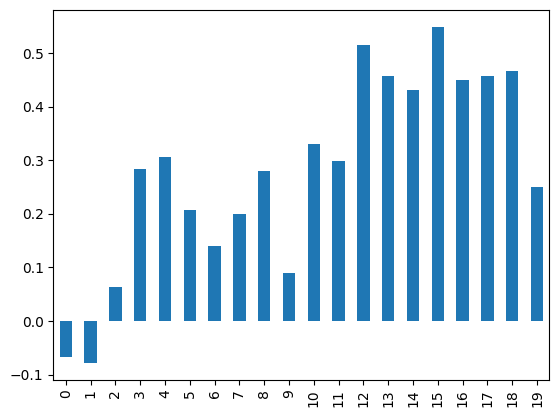

In [6]:
sql = """SELECT
	over
,	COUNT(*)
,	SUM(CAST(batter_runs AS FLOAT)) / COUNT(*) AS avg_runs
FROM balls
WHERE batter = 137
GROUP BY over
ORDER BY over"""

result=%sql {{sql}}
df_gayle=result.DataFrame()
gayle = df_gayle["avg_runs"] - df["avg_runs"]
gayle.plot(kind="bar")
gayle.sum()

...or Virat Kohli (coincidentally #138 at time of computing)

Running query in 'sqlite://///home/mikew/extracover/male_t20.db'

2.1634117665852144

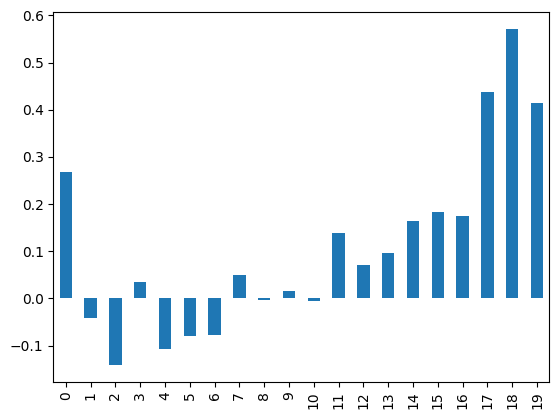

In [7]:
sql = """
SELECT
	over
,	COUNT(*)
,	SUM(CAST(batter_runs AS FLOAT)) / COUNT(*) AS avg_runs
FROM balls
WHERE batter = 138
GROUP BY over
ORDER BY over"""

result=%sql {{sql}}
df_kohli=result.DataFrame()
kohli = df_kohli["avg_runs"] - df["avg_runs"]
kohli.plot(kind="bar")
kohli.sum()

Can we (usefully) fit some kind of curve (straight line) to that?

Or perhaps just smooth the by-over values somehow, perhaps by some weighted average of adjacent (one? more?) values?

Or even just apply the average of the differences to the averall runs-per-ball curve, bumping the probabilities for each score as necessary?

Also, how much do those figures vary over time, or match-by-match, I wonder? Are there discernible trends?

## Average First Innings Totals by City/Venue

In [8]:
sql = """
with first_inns_tots as (
	select b.match_id, m.city, m.venue, sum(b.batter_runs + b.extra_runs) as inns_tot
	from balls b join matches m on m.rowid = b.match_id
	where b.innings = 0
	and match_id in (
		select match_id from balls where innings = 0 group by match_id having count(*) >= 120
	)
	group by match_id
)
select city, venue, count(*), avg(inns_tot), min(inns_tot), max(inns_tot)
from first_inns_tots group by city, venue having count(*) >= 20 order by count(*) desc
"""
%sql {{sql}}

Running query in 'sqlite://///home/mikew/extracover/male_t20.db'

city,venue,count(*),avg(inns_tot),min(inns_tot),max(inns_tot)
Dhaka,"Shere Bangla National Stadium, Mirpur",243,154.7530864197531,82,218
Dubai,Dubai International Cricket Stadium,114,157.99122807017545,80,212
,Dubai International Cricket Stadium,103,152.74757281553397,71,219
Sharjah,Sharjah Cricket Stadium,85,159.5529411764706,90,244
Kolkata,Eden Gardens,76,163.9078947368421,109,232
Mumbai,Wankhede Stadium,76,172.1184210526316,92,240
Abu Dhabi,Sheikh Zayed Stadium,73,151.1917808219178,66,225
Al Amarat,Al Amerat Cricket Ground Oman Cricket (Ministry Turf 1),67,154.67164179104478,86,220
Bangalore,M Chinnaswamy Stadium,63,171.74603174603175,92,263
Birmingham,Edgbaston,61,169.45901639344262,115,242


## Scoring shot frequencies by batsman & over

for players having faced  	enough deliveries to get usual distributions (first attempt: 1000 balls faced)

In [ ]:
# NOTE: this looks like it would benefit from being transformed into a view, but I tried it and it was horribly slower: 26s vs 0.3s

sql = """
SELECT
	over
,	(SUM(CASE WHEN batter_runs = 0 THEN 1 END) + 0.0) / SUM(Count(*)) OVER (PARTITION BY batter, over) AS "0"
,	(SUM(CASE WHEN batter_runs = 1 THEN 1 END) + 0.0) / SUM(Count(*)) OVER (PARTITION BY batter, over) AS "1"
,	(SUM(CASE WHEN batter_runs = 2 THEN 1 END) + 0.0) / SUM(Count(*)) OVER (PARTITION BY batter, over) AS "2"
,	(SUM(CASE WHEN batter_runs = 3 THEN 1 END) + 0.0) / SUM(Count(*)) OVER (PARTITION BY batter, over) AS "3"
,	(SUM(CASE WHEN batter_runs = 4 THEN 1 END) + 0.0) / SUM(Count(*)) OVER (PARTITION BY batter, over) AS "4"
,	(SUM(CASE WHEN batter_runs = 5 THEN 1 END) + 0.0) / SUM(Count(*)) OVER (PARTITION BY batter, over) AS "5"
,	(SUM(CASE WHEN batter_runs = 6 THEN 1 END) + 0.0) / SUM(Count(*)) OVER (PARTITION BY batter, over) AS "6"
FROM
	balls
WHERE innings < 2
AND extra_type = ''
AND batter = 137
GROUP BY over
ORDER BY over
"""

result = %sql {{sql}}
df = result.DataFrame()

Running query in 'sqlite://///home/mikew/extracover/male_t20.db'

<Axes: xlabel='over'>

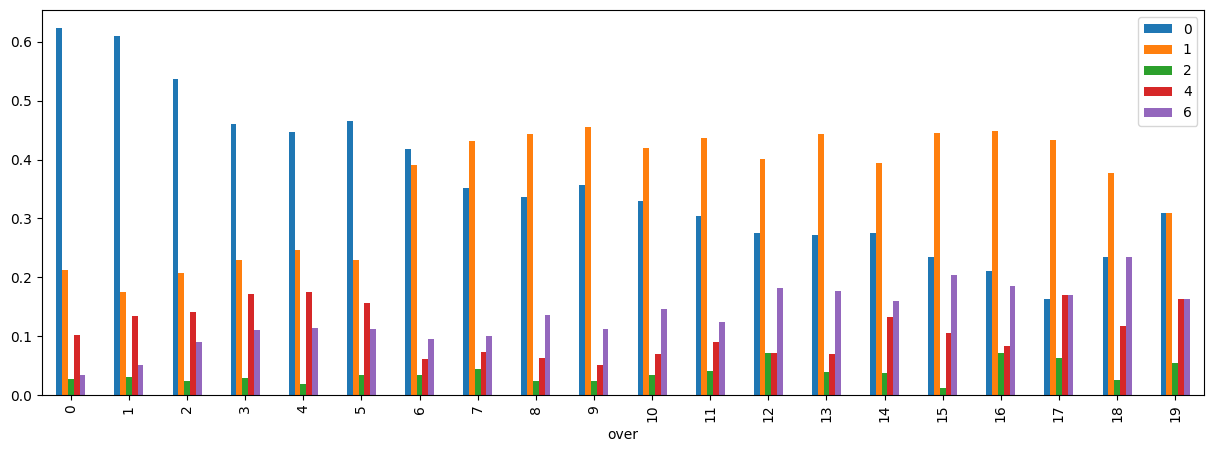

In [ ]:
df.plot(x="over", y=["0", "1", "2", "4", "6"],kind="bar", figsize=(15,5))